In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import xhermes
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Overview

### I tuned fast recycling and went to MFP 0.1 with separate limiters and conduction limitation

# Hermes IO

In [2]:
casestore = dict()

In [3]:
   
db = CaseDB()
toload = [
    dict(name="base", id = "xph1-base_master"),
    dict(name="afn", id = "xph2-afnE"),
    dict(name="no_neutvisc", id = "xph2b-no_neutvisc"),
    dict(name="orig_eqns", id = "xph2c-orig_eqns"),
    dict(name="no_fluxlim", id = "xph2d-no_fluxlim"),
    dict(name="base_nocond", id = "xph1b-base_nocond"),
    dict(name="minmod", id = "xph3-base_minmod"),
    dict(name="minmod_nocond", id = "xph3b-minmod_nocond"),
]
casestore = {}
for case in toload:
    force = True if case["name"] == "no_neutvisc" else False
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True, force_squash = force, use_xhermes = False)

- Reading case xph1-base_master
-----------------------
- Looking for squash file
- Squash file found. squash date 02/20/2024, 16:15:59, dmp file date 02/18/2024, 18:21:29

- Reading case xph2-afnE
-----------------------
- Looking for squash file
- Squash file found. squash date 02/19/2024, 14:33:24, dmp file date 02/19/2024, 13:45:34

- Reading case xph2b-no_neutvisc
-----------------------
- Looking for squash file
- Squash file found. squash date 02/21/2024, 13:47:57, dmp file date 02/19/2024, 16:03:19
- Done

- Reading case xph2c-orig_eqns
-----------------------
- Looking for squash file
- Squash file found. squash date 02/20/2024, 15:45:54, dmp file date 02/20/2024, 12:30:22

- Reading case xph2d-no_fluxlim
-----------------------
- Looking for squash file
- Squash file found. squash date 02/20/2024, 15:46:54, dmp file date 02/20/2024, 15:28:37

- Reading case xph1b-base_nocond
-----------------------
- Looking for squash file
- Squash file found. squash date 02/21/2024, 13:48:2

In [4]:
plt.close("all")
%matplotlib inline

## Read Hermes data

In [5]:
hr = dict()
for name in casestore.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(casestore[name].ds.isel(t=-1, x = slice(2,-2)))
    
    if "afnE" in  name:
        new_afn = True
        print(f"Loading {name} with new AFN")
    else:
        new_afn = False
        print(f"Loading {name} with old AFN")
    
    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = new_afn)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

base
Loading base with old AFN
afn
Loading afn with old AFN
no_neutvisc
Loading no_neutvisc with old AFN
orig_eqns
Loading orig_eqns with old AFN
no_fluxlim
Loading no_fluxlim with old AFN
base_nocond
Loading base_nocond with old AFN
minmod
Loading minmod with old AFN
minmod_nocond
Loading minmod_nocond with old AFN


# Read SOLEDGE CSV data

In [6]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

## Read SOLPS

In [7]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

# Runtime

(0.0, 30000000.0)

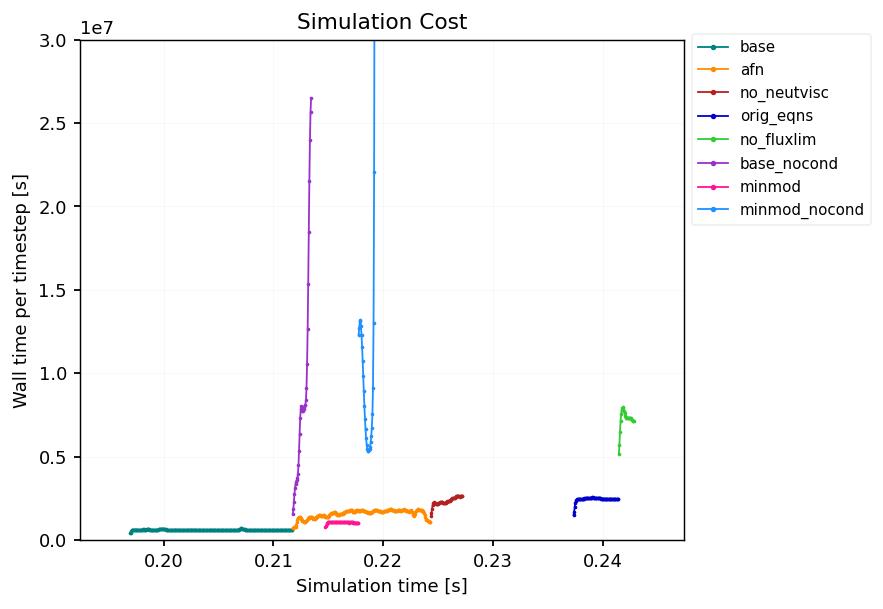

In [11]:
fig, ax = plt.subplots(dpi = 130)

colors = ["limegreen", "gold", "darkorange", "red", "firebrick", "skyblue", "navy"]

for i, case in enumerate(casestore):
    ds = casestore[case].ds
    wtime = ds["wtime"][:-1].values
    tstep = ds["t"].diff("t").values
    
    wtime_per_tstep = wtime/tstep
    time = ds["t"][:-1].values
    # time -= time[0]

    
    ax.plot(time, scipy.ndimage.gaussian_filter1d(wtime_per_tstep, 2), label = case,  lw = 1, marker = "o", ms = 1)
    
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Wall time per timestep [s]")
ax.set_title("Simulation Cost")
ax.set_ylim(0,3e7)
# ax.set_xlim(None,0.614688)

# Poloidal temps

In [13]:
case

'minmod_nocond'

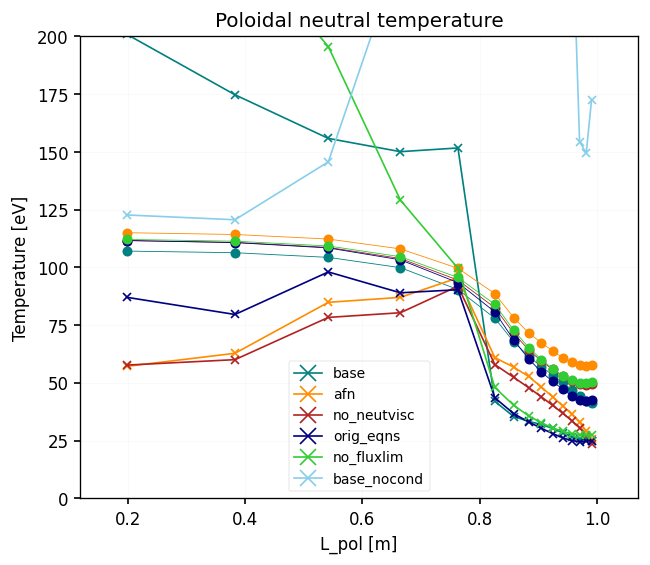

In [15]:
# locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'noafn_old', 'noafn_new']
colors = ["teal", "darkorange", "firebrick", "navy", "limegreen", "skyblue"]

for cases in [casestore]:
    
    # colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
    fig, ax = plt.subplots(dpi = 120)

    for i, case in enumerate(cases):
        if "minmod" not in case:
            ds = casestore[case].ds.isel(t=-1)
            m = ds.metadata
            fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
            dist = np.cumsum(fl["dl"])
            
            if any([x in case for x in ["form2", "form4"]]):
                m = "x"
            elif any([x in case for x in ["form1", "form3"]]):
                m = "+"
            else:
                m = "x"
            ax.plot(dist, fl["Td"], label = case, marker = m, ms = 5, lw = 1, color = colors[i])
            ax.plot(dist, fl["Td+"],  marker = "o", ms = 5, lw = 0.5, c = colors[i])
    # ax.set_yscale("symlog", linthresh = 1e-3)
    ax.set_xlabel("L_pol [m]")
    ax.set_ylabel("Temperature [eV]")
    ax.set_title("Poloidal neutral temperature")
    ax.legend(fontsize="small")
    ax.set_ylim(0,200)

### Minmod

(0.0, 300.0)

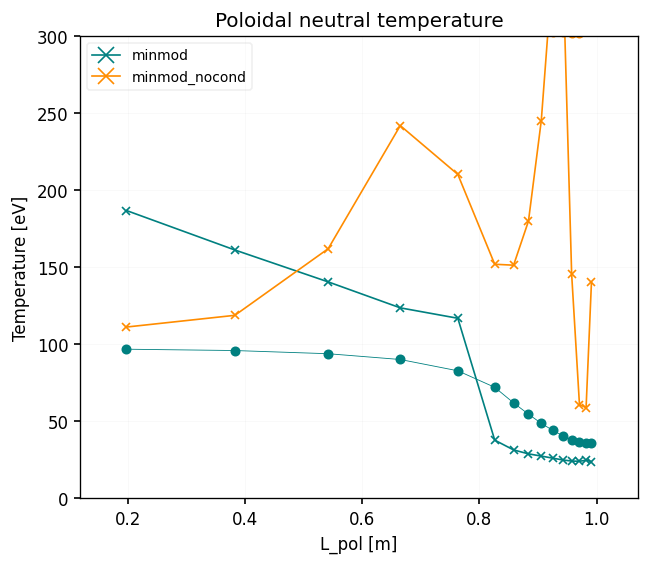

In [20]:
# locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'noafn_old', 'noafn_new']
colors = ["teal", "darkorange", "firebrick", "navy", "limegreen", "skyblue"]

cases = [x for x in casestore.keys() if "minmod" in x]
    
# colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
fig, ax = plt.subplots(dpi = 120)

for i, case in enumerate(cases):
    ds = casestore[case].ds.isel(t=-1)
    m = ds.metadata
    fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
    dist = np.cumsum(fl["dl"])
    
    if any([x in case for x in ["form2", "form4"]]):
        m = "x"
    elif any([x in case for x in ["form1", "form3"]]):
        m = "+"
    else:
        m = "x"
    ax.plot(dist, fl["Td"], label = case, marker = m, ms = 5, lw = 1, color = colors[i])
    ax.plot(dist, fl["Td+"],  marker = "o", ms = 5, lw = 0.5, c = colors[i])
# ax.set_yscale("symlog", linthresh = 1e-3)
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title("Poloidal neutral temperature")
ax.legend(fontsize="small")
ax.set_ylim(0,300)

## Lineplots vs. soledge

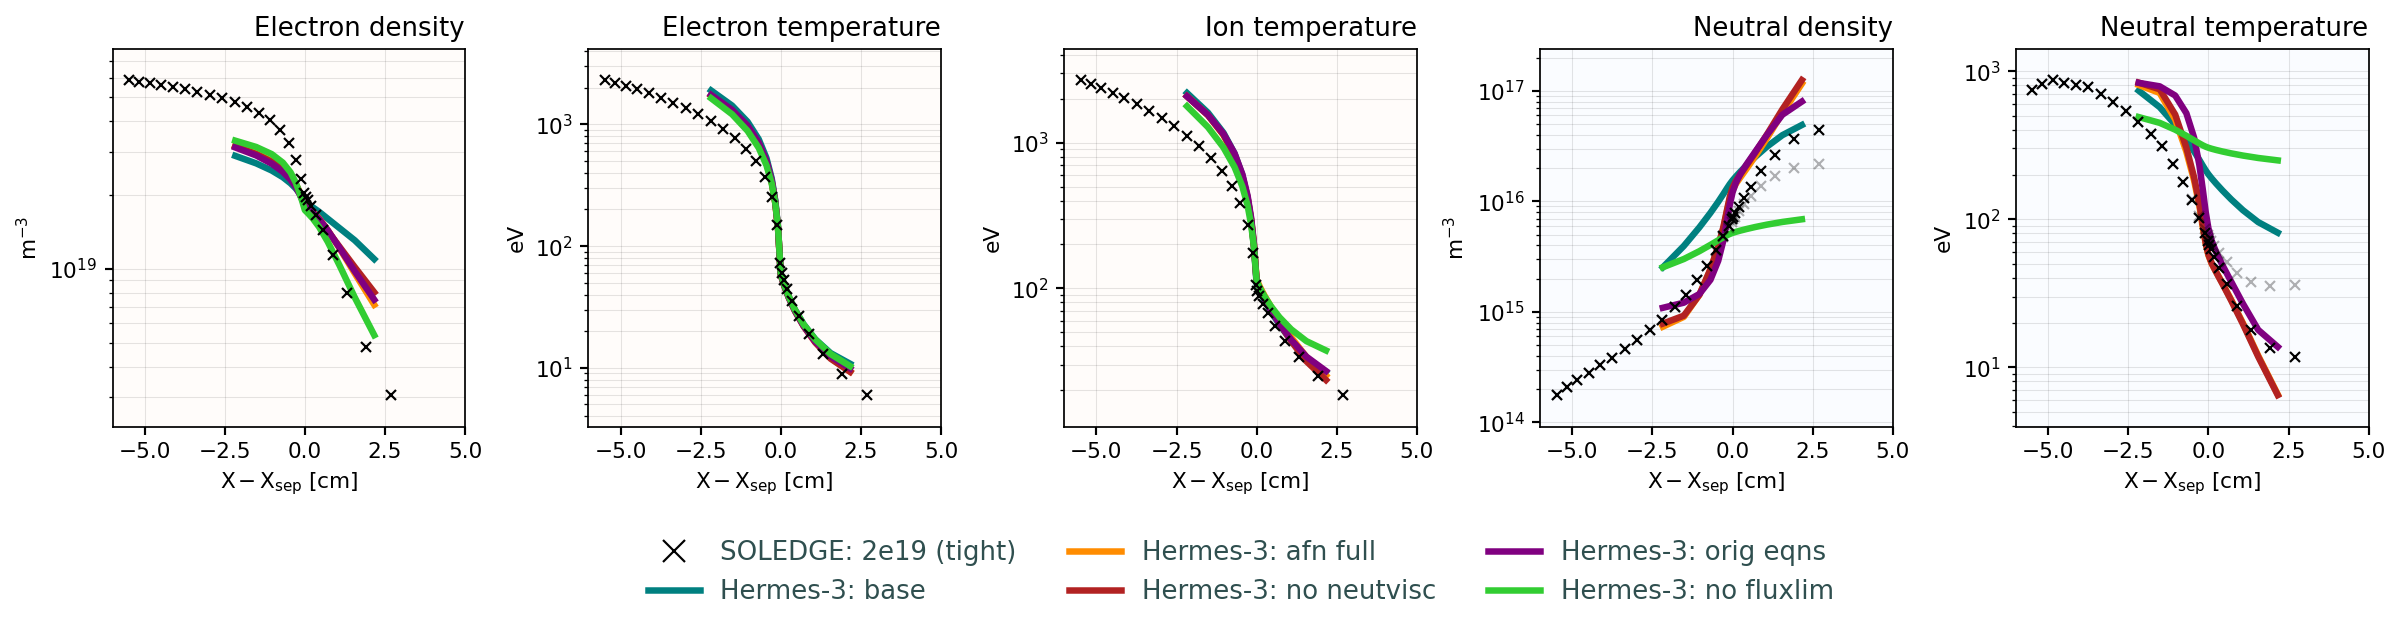

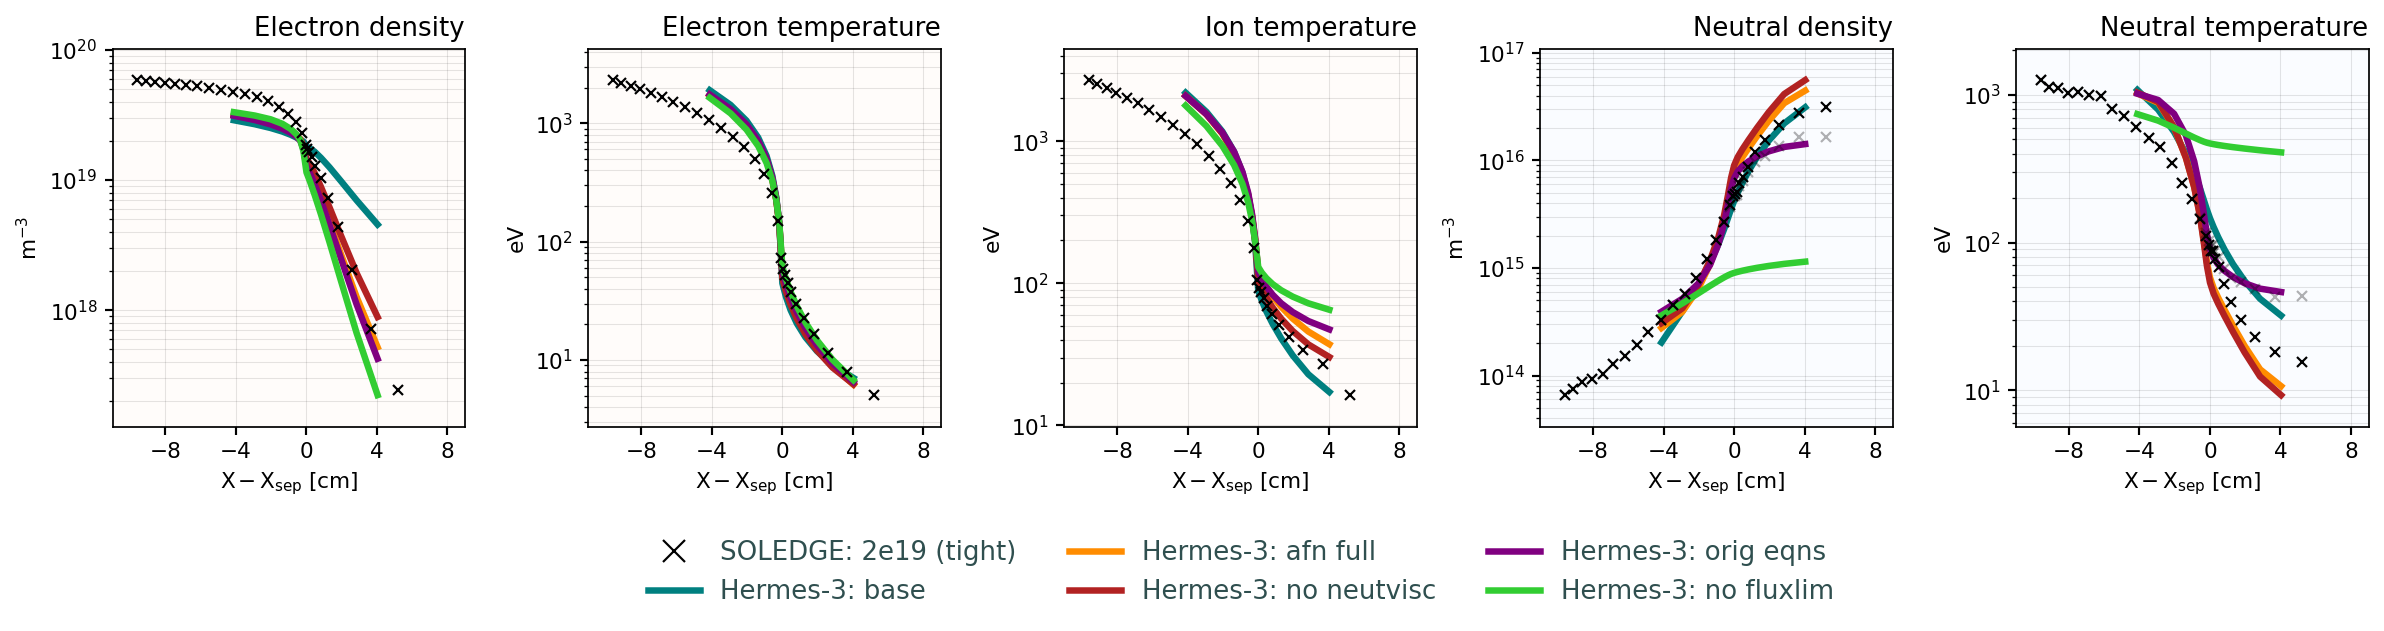

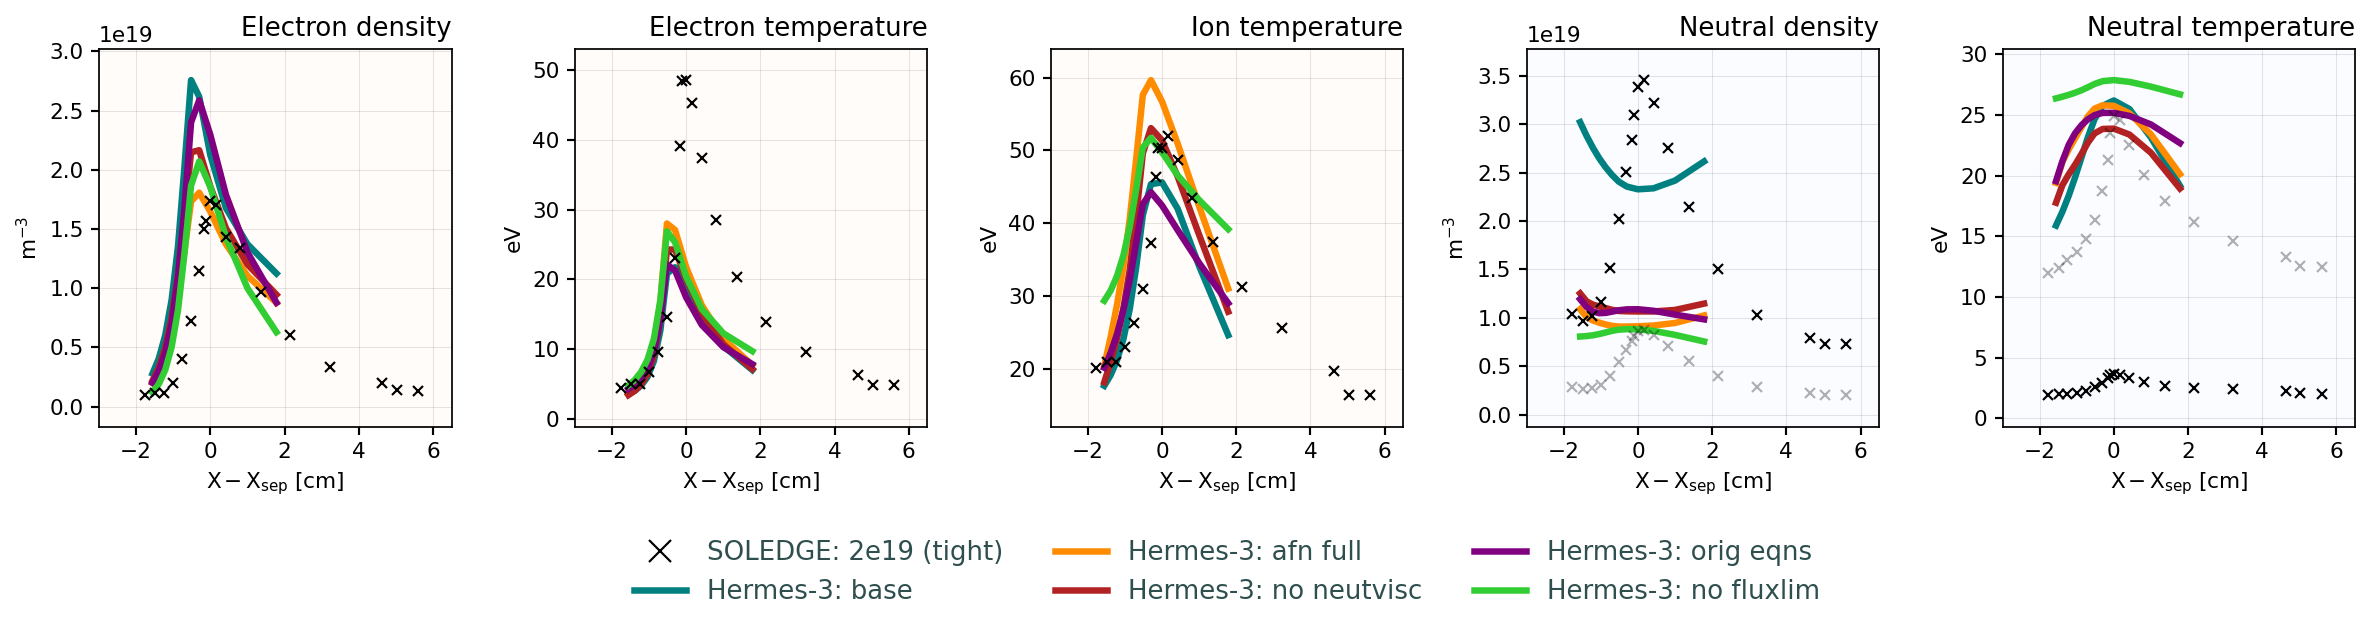

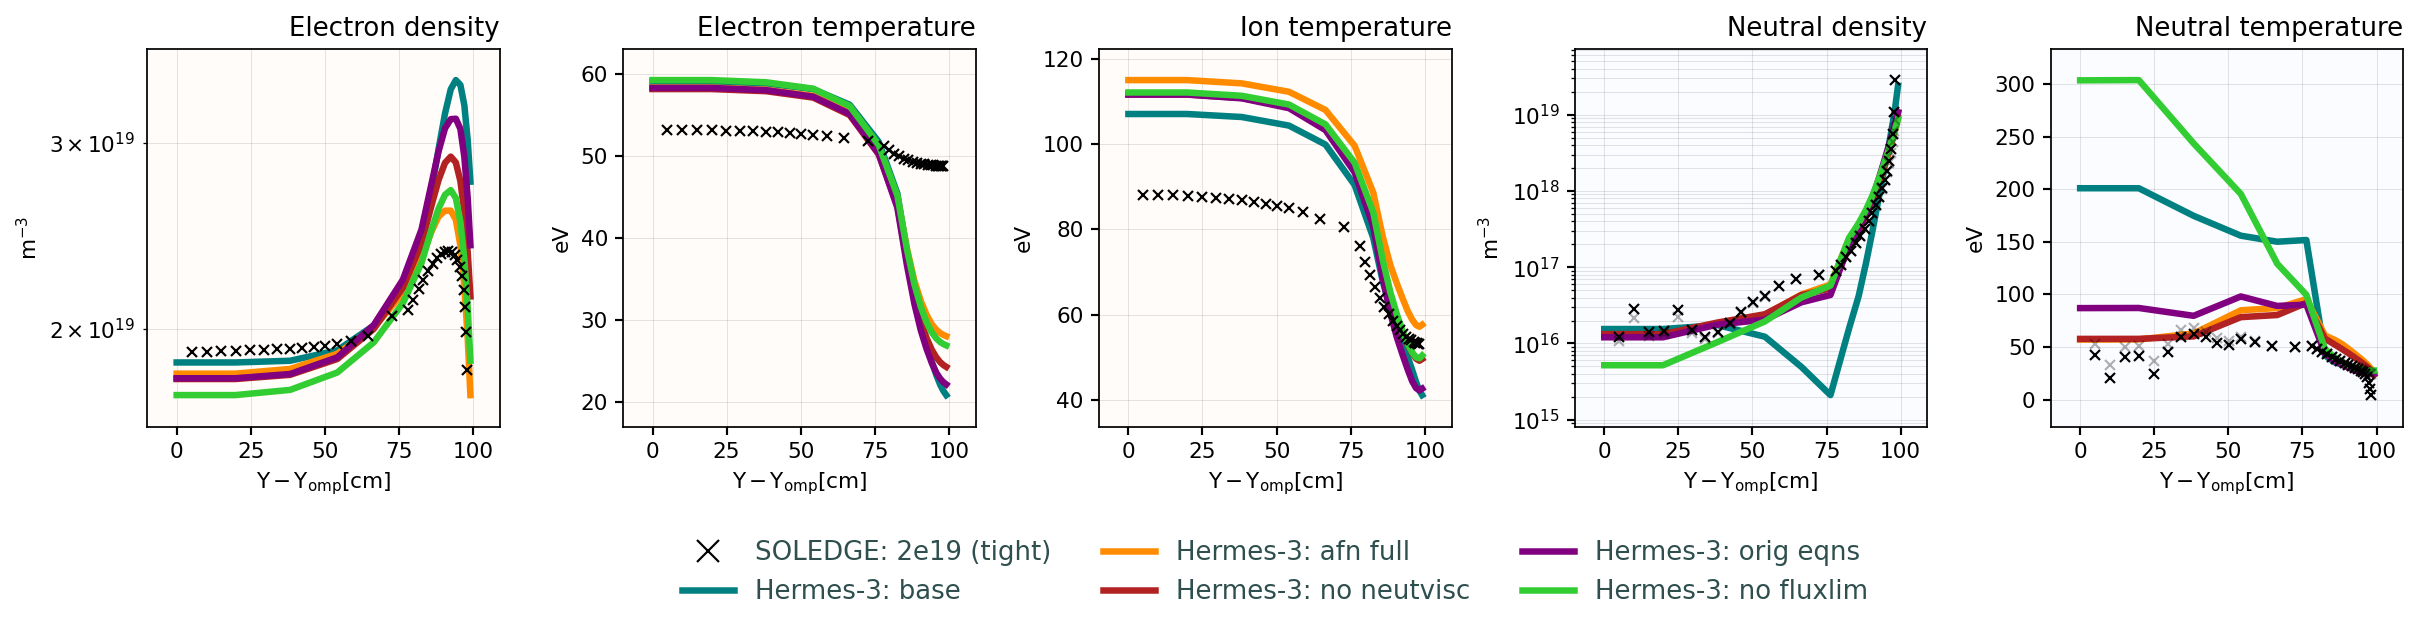

In [10]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    r"Hermes-3: base" : dict(data=hr['base'], color = "teal"),
    r"Hermes-3: afn full" : dict(data=hr['afn'], color = "darkorange"),
    r"Hermes-3: no neutvisc" : dict(data=hr['no_neutvisc'], color = "firebrick"),
    r"Hermes-3: orig eqns" : dict(data=hr['orig_eqns'], color = "purple"),
    r"Hermes-3: no fluxlim" : dict(data=hr['no_fluxlim'], color = "limegreen"),

    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"], 
    # regions = ["omp"],
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    combine_molecules = True,
    mode = "log",
    dpi = 120,
    lw = 2
)

In [10]:
print("\n## BASE")
calculate_simple_heat_balance(casestore["afnE_base"].ds.isel(t=-1))
print("\n## FIXES")
calculate_simple_heat_balance(casestore["afnE_fixes"].ds.isel(t=-1))
print()


## BASE
Wall reflective cooling:
inner_wall  : -0.009 [MW]
outer_wall  : -0.078 [MW]
pfr         : -0.083 [MW]
targets     : -0.038 [MW]
Total       : -0.207 [MW]

Recycling neutral energy source:
Total       : 0.417 [MW]

## FIXES
Wall reflective cooling:
inner_wall  : -0.011 [MW]
outer_wall  : -0.078 [MW]
pfr         : -0.078 [MW]
targets     : -0.064 [MW]
Total       : -0.232 [MW]

Recycling neutral energy source:
Total       : 0.407 [MW]



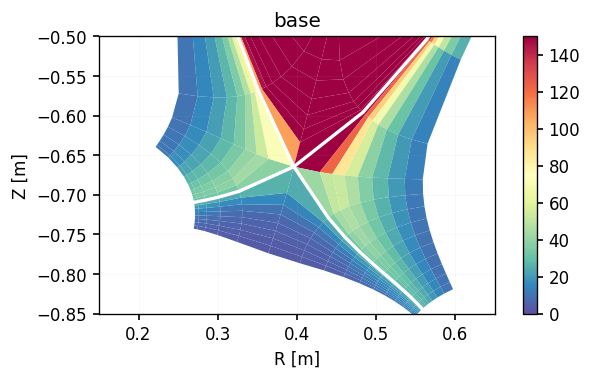

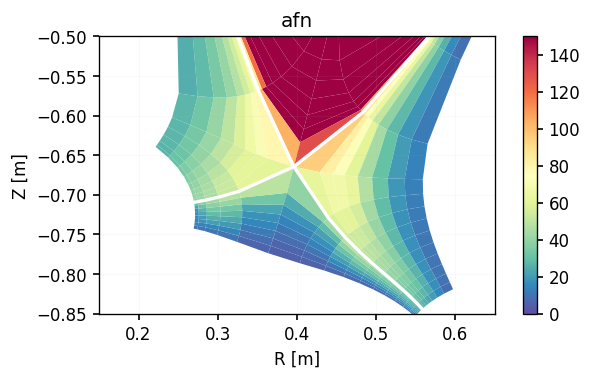

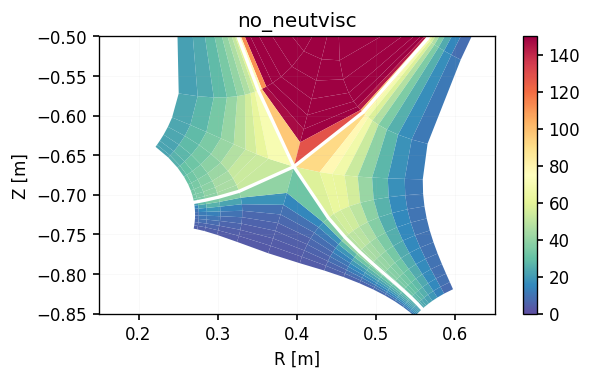

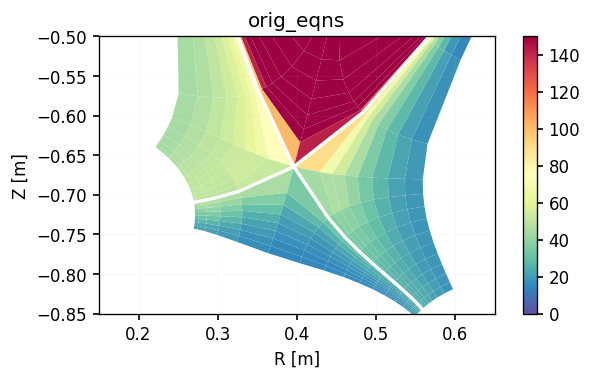

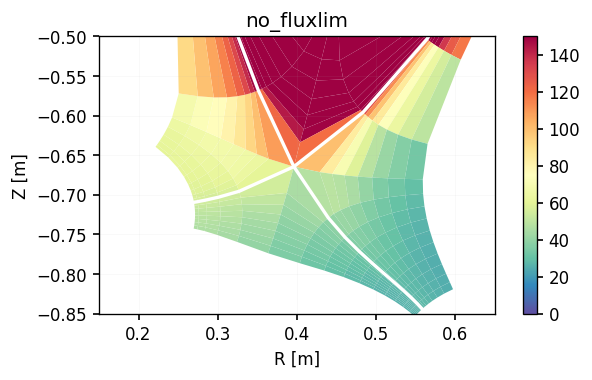

In [11]:
for case in [x for x in casestore.keys() if "notune" not in x]:
    fig, ax = plt.subplots(figsize = (6,3))
    ds = casestore[case].ds.isel(t=-1)
    ds["Td"].hermesm.clean_guards().bout.polygon(ax, cmap = "Spectral_r", vmax = 150, vmin = 0, antialias = True)
    ax.set_ylim(-0.85, -0.5)
    ax.set_xlim(0.15,0.65)
    ax.set_title(case)

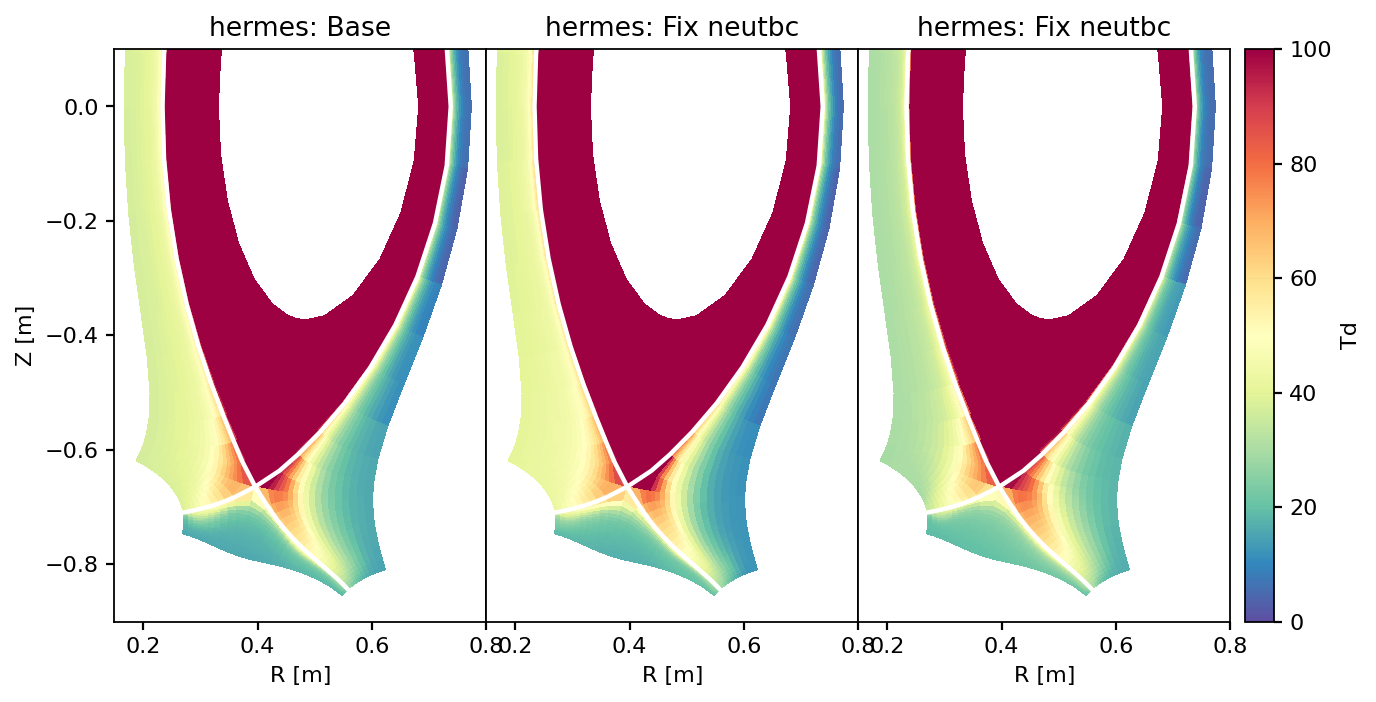

In [9]:
plt.close("all")
v = viewer_2d(
    "Td",
    [
        # {"name" : "Tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name" : r"Base", "code" : "hermes", "ds" : casestore['afnE_base'].ds.isel(t=-1)},
        {"name" : r"plim 0.5", "code" : "hermes", "ds" : casestore['afnE_plim_0.5'].ds.isel(t=-1)},
        {"name" : r"plim 10", "code" : "hermes", "ds" : casestore['afnE_plim_10'].ds.isel(t=-1)},
    ],
    logscale = False,
    vmin = 0,
    vmax = 100,
    # vmin = 1e17,
    # vmax = 1e19,
    dpi = 160,
    ylim = (-0.9,0.1),
    xlim = (0.15, 0.8),
    wspace = 0.0,
    cmap = "Spectral_r",
    slider = False,
)